In [3]:
# Critical to get imports working
# https://stackoverflow.com/questions/39299838/how-do-i-import-module-in-jupyter-notebook-directory-into-notebooks-in-lower-dir

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import src.utilities.segmentation.brute.grayscale_segmentation as seg

import src.utilities.segmentation.xianauto.automatic_segmentation as xian

from src.constants.ultrasoundConstants import (
    FRAME_DEFAULT_ROW_CROP_FOR_SCAN_SELECTION,
    FRAME_DEFAULT_COL_CROP_FOR_SCAN_SELECTION
)

In [6]:
def absolute_max(ndarray):
    return np.max(ndarray.flatten())

def absolute_min(ndarray):
    return np.min(ndarray.flatten())

def get_region(image, start, end):
    return image[start[0]:end[0], start[1]:end[1]]

### Load frame from file

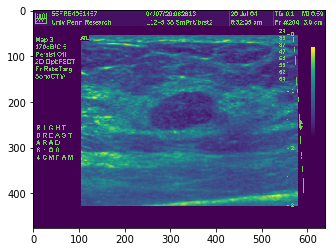

In [15]:
frame = cv2.imread("../../TestImages/frames/frame_0003.png", cv2.IMREAD_GRAYSCALE)
M, N = frame.shape

plt.imshow(frame)

### Select scan window from frame

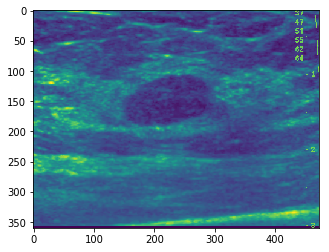

In [16]:
scan_window, scan_bounds = seg.select_scan_window_from_frame(
    frame, 
    0,
    255,
    select_bounds = (
        slice(FRAME_DEFAULT_ROW_CROP_FOR_SCAN_SELECTION, M), 
        slice(FRAME_DEFAULT_COL_CROP_FOR_SCAN_SELECTION, N)))

plt.imshow(scan_window)

### Determine seed point in scan window 

In [21]:
SEED_REGION_RADIUS = 5

_, seed_pt = xian.get_ROI_debug(scan_window)
seed_pt = np.flip(seed_pt.astype(int), axis=0)

## Rectangle bounds

start_pt = seed_pt - SEED_REGION_RADIUS
end_pt = seed_pt + SEED_REGION_RADIUS

## Seed region mask 

In [22]:
M_SW, N_SW = scan_window.shape
image_mask = np.zeros((M_SW, N_SW), np.uint8)

## Circular seed image
cv2.circle(
    image_mask,
    tuple(seed_pt.astype(np.uint8)),
    HALF_WIDTH,
    1,
    -1)

## Rectangular seed image
# cv2.rectangle(
#     image_mask, 
#     tuple(start_pt),
#     tuple(end_pt), 
#     1,
#     -1)

seed_region = (cv2.bitwise_and(scan_window, scan_window, mask=image_mask) > 0).astype(np.uint8)

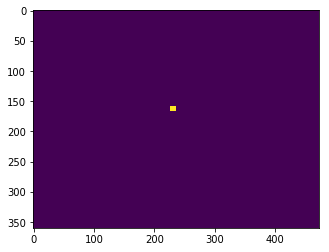

In [23]:
plt.imshow(image_mask)

### Tresholding by seed region min/max

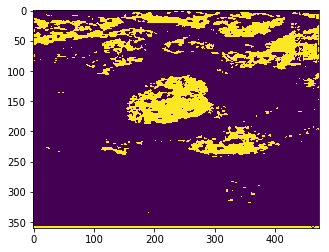

In [24]:
region = get_region(scan_window, start_pt, end_pt)
region_min = absolute_min(region)
region_max = absolute_max(region)

ret, thresh = cv2.threshold(scan_window, region_min, region_max, cv2.THRESH_BINARY_INV)

plt.imshow(thresh)

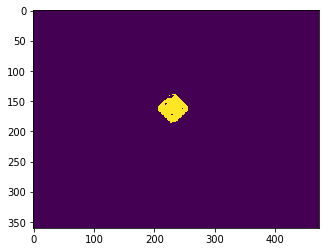

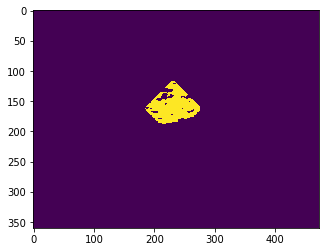

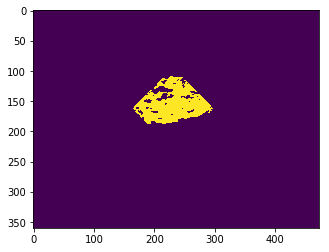

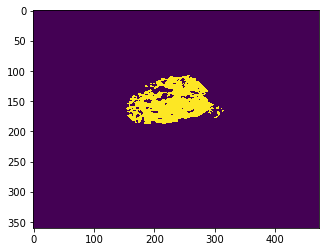

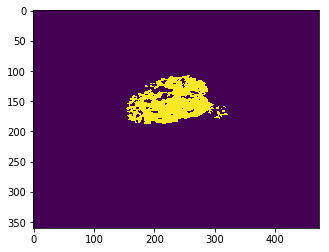

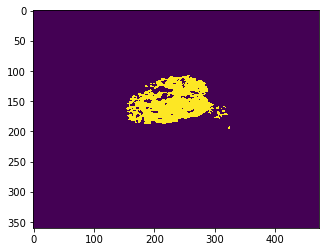

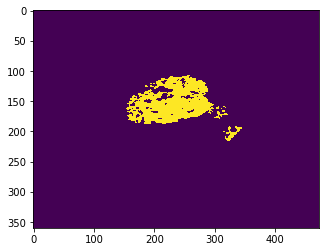

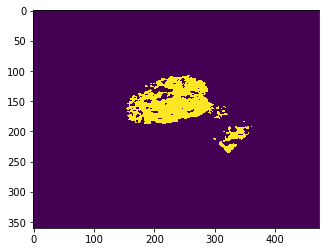

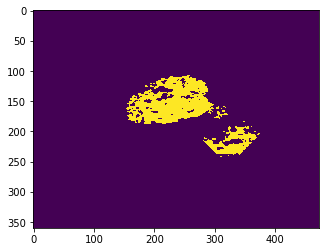

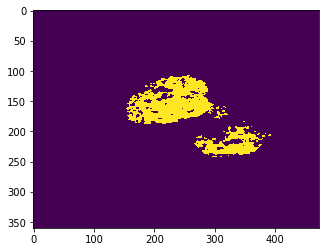

In [40]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
expanded = np.copy(seed_region)

for i in range(10):
    dilated = cv2.dilate(expanded, kernel, iterations = 20)
    expanded = cv2.bitwise_and(dilated, thresh)